[View in Colaboratory](https://colab.research.google.com/github/aseria/mlcc/blob/test/intro_to_neural_nets.ipynb)

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # 신경망 소개

 **학습 목표:**
  * 텐서플로우의 `DNNRegressor` 클래스를 사용하여 신경망(NN) 및 히든 레이어를 정의한다
  * 비선형성을 갖는 데이터 세트를 신경망에 학습시켜 선형 회귀 모델보다 우수한 성능을 달성한다

 이전 실습에서는 모델에 비선형성을 통합하는 데 도움이 되는 합성 특성을 사용했습니다.

비선형성을 갖는 대표적인 세트는 위도와 경도였지만 다른 특성도 있을 수 있습니다.

일단 이전 실습의 로지스틱 회귀 작업이 아닌 표준 회귀 작업으로 돌아가겠습니다. 즉, `median_house_value`를 직접 예측할 것입니다.

 ## 설정

우선 데이터를 로드하고 준비하겠습니다.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [4]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.5,28.5,2647.1,541.0,1430.6,502.3,3.9,2.0
std,2.1,2.0,12.5,2192.1,421.8,1104.6,383.5,1.9,1.1
min,32.5,-124.3,1.0,8.0,1.0,9.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1460.0,296.0,790.0,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2131.5,436.0,1169.0,410.5,3.5,1.9
75%,37.7,-118.0,37.0,3146.0,652.0,1728.0,608.0,4.7,2.3
max,42.0,-114.3,52.0,37937.0,5471.0,16122.0,5189.0,15.0,52.0


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.7,-119.6,28.9,2635.4,535.5,1427.1,498.7,3.9,2.0
std,2.1,2.0,12.7,2150.7,420.8,1245.7,387.0,1.9,1.3
min,32.5,-124.3,2.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1466.0,297.0,788.0,282.0,2.6,1.5
50%,34.3,-118.5,29.0,2116.5,430.0,1161.0,405.0,3.6,1.9
75%,37.7,-118.0,37.0,3163.2,641.0,1701.2,597.0,4.8,2.3
max,41.9,-114.6,52.0,32627.0,6445.0,35682.0,6082.0,15.0,55.2


Training targets summary:


,median_house_value
count,12000.0
mean,206.5
std,115.5
min,15.0
25%,119.2
50%,179.2
75%,264.3
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,209.2
std,117.1
min,15.0
25%,120.6
50%,181.8
75%,266.7
max,500.0


 ## 신경망 구축

NN은 [DNNRegressor](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/DNNRegressor) 클래스에 의해 정의됩니다.

**`hidden_units`**를 사용하여 NN의 구조를 정의합니다.  `hidden_units` 인수는 정수의 목록을 제공하며, 각 정수는 히든 레이어에 해당하고 포함된 노드의 수를 나타냅니다. 예를 들어 아래 대입식을 살펴보세요.

`hidden_units=[3,10]`

위 대입식은 히든 레이어 2개를 갖는 신경망을 지정합니다.

* 1번 히든 레이어는 노드 3개를 포함합니다.
* 2번 히든 레이어는 노드 10개를 포함합니다.

레이어를 늘리려면 목록에 정수를 더 추가하면 됩니다. 예를 들어 `hidden_units=[10,20,30,40]`은 각각 10개, 20개, 30개, 40개의 유닛을 갖는 4개의 레이어를 만듭니다.

기본적으로 모든 히든 레이어는 ReLu 활성화를 사용하며 완전 연결성을 갖습니다.

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units
  )
  
  # Create input functions
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor

 ## 작업 1: NN 모델 학습

**RMSE를 110 미만으로 낮추는 것을 목표로 초매개변수를 조정합니다.**

다음 블록을 실행하여 NN 모델을 학습시킵니다.  

많은 특성을 사용한 선형 회귀 실습에서 RMSE이 110 정도면 상당히 양호하다고 설명한 바 있습니다.  더 우수한 모델을 목표로 해 보겠습니다.

이번에 수행할 작업은 다양한 학습 설정을 수정하여 검증 데이터에 대한 정확성을 높이는 것입니다.

NN에는 과적합이라는 위험이 도사리고 있습니다.  학습 데이터에 대한 손실과 검증 데이터에 대한 손실의 격차를 조사하면 모델에서 과적합이 시작되고 있는지를 판단하는 데 도움이 됩니다. 일반적으로 격차가 증가하기 시작하면 과적합의 확실한 증거가 됩니다.

매우 다양한 설정이 가능하므로, 각 시도에서 설정을 잘 기록하여 개발 방향을 잡는 데 참고하는 것이 좋습니다.

또한 괜찮은 설정을 발견했다면 여러 번 실행하여 결과의 재현성을 확인하시기 바랍니다. NN 가중치는 일반적으로 작은 무작위 값으로 초기화되므로 실행 시마다 약간의 차이를 보입니다.


Training model...
RMSE (on training data):
  period 00 : 162.42
  period 01 : 154.85
  period 02 : 151.33
  period 03 : 152.92
  period 04 : 139.68
  period 05 : 144.82
  period 06 : 129.42
  period 07 : 124.92
  period 08 : 121.83
  period 09 : 119.91
Model training finished.
Final RMSE (on training data):   119.91
Final RMSE (on validation data): 122.21


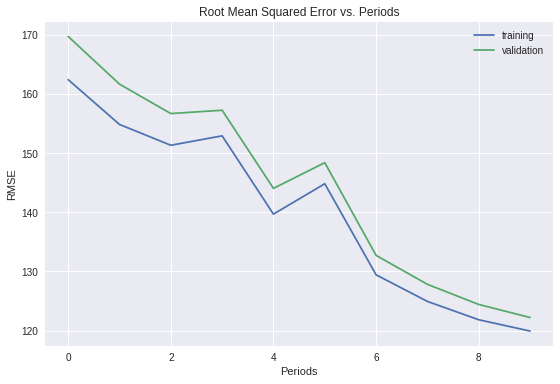

In [8]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    hidden_units=[10, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 232.59
  period 01 : 231.54
  period 02 : 226.95
  period 03 : 130.32
  period 04 : 125.55
  period 05 : 108.67
  period 06 : 104.56
  period 07 : 103.70
  period 08 : 112.44
  period 09 : 101.95
Model training finished.
Final RMSE (on training data):   101.95
Final RMSE (on validation data): 105.57


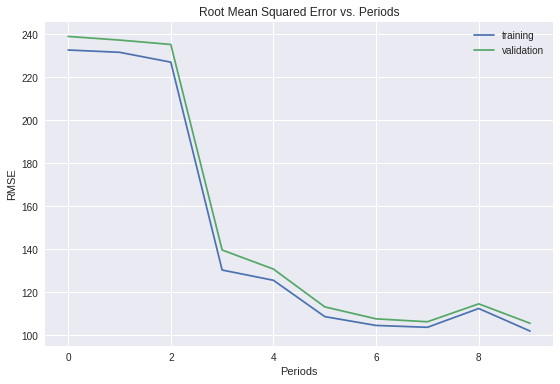

In [12]:
# Re?
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    hidden_units=[10, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 235.92
  period 01 : 235.65
  period 02 : 235.40
  period 03 : 235.14
  period 04 : 234.88
  period 05 : 234.85
  period 06 : 234.48
  period 07 : 234.25
  period 08 : 233.68
  period 09 : 156.71
Model training finished.
Final RMSE (on training data):   156.71
Final RMSE (on validation data): 158.72


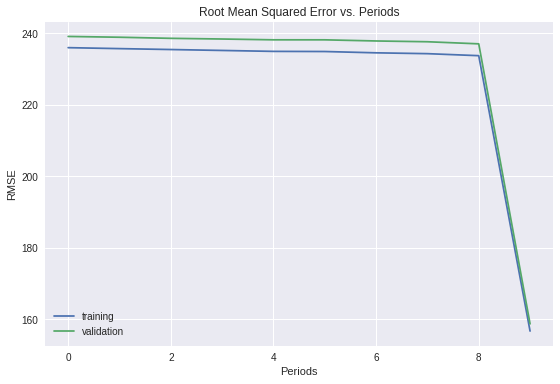

In [15]:
#Re Re
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    hidden_units=[10, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### 조절해보면?

Training model...
RMSE (on training data):
  period 00 : 234.75
  period 01 : 233.95
  period 02 : 233.34
  period 03 : 232.83
  period 04 : 232.37
  period 05 : 231.96
  period 06 : 231.59
  period 07 : 231.24
  period 08 : 230.91
  period 09 : 230.60
Model training finished.
Final RMSE (on training data):   230.60
Final RMSE (on validation data): 233.72


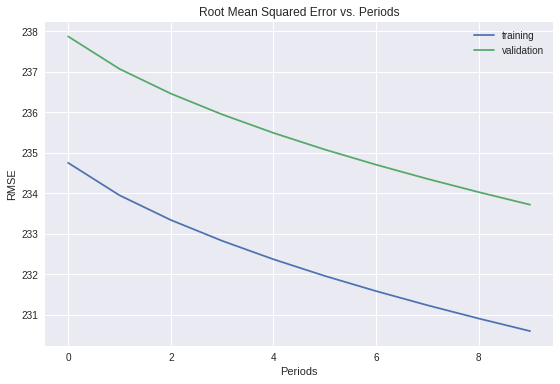

In [16]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=5000,
    batch_size=50,
    hidden_units=[4,4,4, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 108.45
  period 01 : 105.88
  period 02 : 104.15
  period 03 : 102.95
  period 04 : 101.79
  period 05 : 101.52
  period 06 : 99.70
  period 07 : 99.79
  period 08 : 97.80
  period 09 : 96.62
Model training finished.
Final RMSE (on training data):   96.62
Final RMSE (on validation data): 98.48


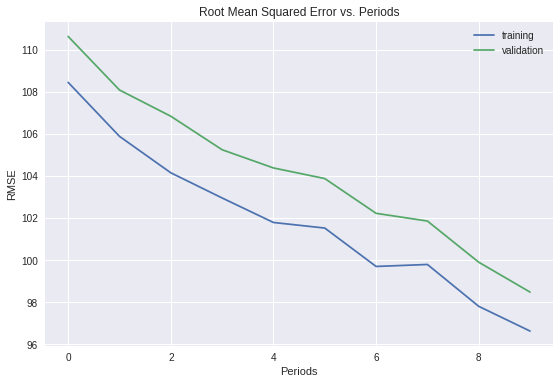

In [17]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=5000,
    batch_size=50,
    hidden_units=[4,4,4, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ### 해결 방법

가능한 해결 방법을 보려면 아래를 클릭하세요.

 **참고:** 이 매개변수 선택은 어느 정도 임의적인 것입니다. 여기에서는 오차가 목표치 아래로 떨어질 때까지 점점 복잡한 조합을 시도하면서 학습 시간을 늘렸습니다. 이 조합은 결코 최선의 조합이 아니며, 다른 조합이 더 낮은 RMSE를 달성할 수도 있습니다. 오차를 최소화하는 모델을 찾는 것이 목표라면 매개변수 검색과 같은 보다 엄밀한 절차를 사용해야 합니다.

In [0]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## 작업 2: 테스트 데이터로 평가

**검증 성능 결과가 테스트 데이터에 대해서도 유지되는지 확인합니다.**

만족할 만한 모델이 만들어졌으면 테스트 데이터로 평가하고 검증 성능과 비교해 봅니다.

테스트 데이터 세트는 [여기](https://dl.google.com/mlcc/mledu-datasets/california_housing_test.csv)에 있습니다.

In [18]:
california_housing_test_data = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_test.csv", sep=",")

# YOUR CODE HERE
test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda: my_input_fn(test_examples, 
                                               test_targets["median_house_value"], 
                                               num_epochs=1, 
                                               shuffle=False)

test_predictions = dnn_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

rmse = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % rmse)

Final RMSE (on test data): 95.61


 ### 해결 방법

가능한 해결 방법을 보려면 아래를 클릭하세요.

 위 코드에서 수행하는 작업과 마찬가지로 적절한 데이터 파일을 로드하고 전처리한 후 predict 및 mean_squared_error를 호출해야 합니다.

모든 레코드를 사용할 것이므로 테스트 데이터를 무작위로 추출할 필요는 없습니다.

In [0]:
california_housing_test_data = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_testing_input_fn = lambda: my_input_fn(test_examples, 
                                               test_targets["median_house_value"], 
                                               num_epochs=1, 
                                               shuffle=False)

test_predictions = dnn_regressor.predict(input_fn=predict_testing_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

## 추가 과제: 정규화해보기

In [0]:
def train_nn_regression_model_with_regularization(
    dnn_regressor,
    learning_rate,
    steps,
    step_per_period,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    l1_regularization_strength=0,
    l2_regularization_strength=0):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = steps/step_per_period
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate,
                                        l1_regularization_strength = l1_regularization_strength,
                                        l2_regularization_strength = l2_regularization_strength)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
#   dnn_regressor = tf.estimator.DNNRegressor(
#       feature_columns=construct_feature_columns(training_examples),
#       hidden_units=hidden_units
#   )
  
  # Create input functions
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor

In [0]:
dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=[4,4,4, 2]
  )

Training model...
RMSE (on training data):
  period 00 : 153.89
  period 01 : 133.12
  period 02 : 113.62
  period 03 : 107.97
  period 04 : 106.82
  period 05 : 106.32
  period 06 : 106.34
  period 07 : 105.90
  period 08 : 104.96
  period 09 : 104.80
  period 10 : 104.31
  period 11 : 103.87
  period 12 : 103.54
  period 13 : 102.72
  period 14 : 102.17
  period 15 : 101.93
  period 16 : 101.39
  period 17 : 102.04
  period 18 : 100.90
  period 19 : 100.81
  period 20 : 100.14
  period 21 : 99.92
  period 22 : 100.96
  period 23 : 99.16
  period 24 : 98.64
  period 25 : 99.63
  period 26 : 98.73
  period 27 : 98.03
  period 28 : 98.30
  period 29 : 97.53
  period 30 : 97.75
  period 31 : 97.15
  period 32 : 97.79
  period 33 : 96.96
  period 34 : 97.09
  period 35 : 96.48
  period 36 : 96.18
  period 37 : 96.17
  period 38 : 96.55
  period 39 : 95.46
  period 40 : 95.62
  period 41 : 95.18
  period 42 : 96.39
  period 43 : 94.77
  period 44 : 94.74
  period 45 : 94.66
  period 46 : 9

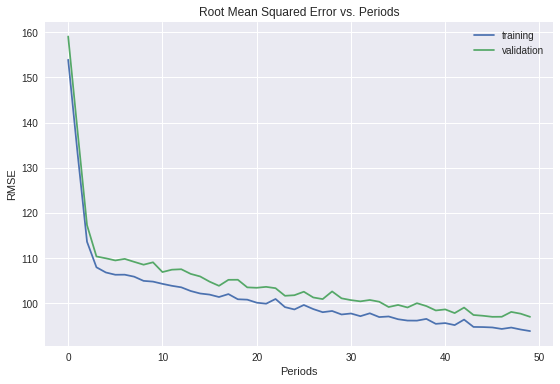

In [31]:
dnn_regressor_trained = train_nn_regression_model_with_regularization(
    dnn_regressor=dnn_regressor,
    learning_rate=0.01,
    steps=5000,
    step_per_period=100,
    batch_size=50,
    hidden_units=[4,4,4, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    l1_regularization_strength = 0.01)

Training model...
RMSE (on training data):
  period 00 : 162.47
  period 01 : 158.01
  period 02 : 146.25
  period 03 : 131.96
  period 04 : 114.53
  period 05 : 106.82
  period 06 : 104.58
  period 07 : 103.20
  period 08 : 100.04
  period 09 : 99.31
  period 10 : 99.06
  period 11 : 98.39
  period 12 : 98.01
  period 13 : 97.76
  period 14 : 100.59
  period 15 : 98.47
  period 16 : 97.06
  period 17 : 96.99
  period 18 : 97.08
  period 19 : 96.82
  period 20 : 96.88
  period 21 : 97.90
  period 22 : 97.16
  period 23 : 95.82
  period 24 : 95.78
  period 25 : 95.95
  period 26 : 97.62
  period 27 : 95.78
  period 28 : 95.33
  period 29 : 95.55
  period 30 : 95.40
  period 31 : 95.20
  period 32 : 94.96
  period 33 : 94.83
  period 34 : 94.78
  period 35 : 95.22
  period 36 : 95.25
  period 37 : 94.44
  period 38 : 94.89
  period 39 : 94.24
  period 40 : 94.24
  period 41 : 94.43
  period 42 : 93.93
  period 43 : 94.08
  period 44 : 95.34
  period 45 : 93.75
  period 46 : 94.61
  perio

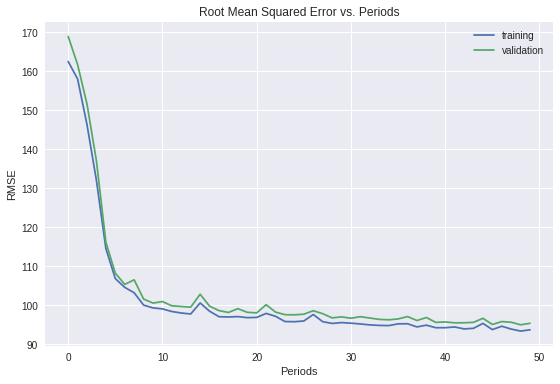

In [33]:
dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=[4,4,4, 2]
  )
dnn_regressor_trained2 = train_nn_regression_model_with_regularization(
    dnn_regressor=dnn_regressor,
    learning_rate=0.01,
    steps=5000,
    step_per_period=100,
    batch_size=50,
    hidden_units=[4,4,4, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    l2_regularization_strength = 0.01)